# Heart Failure Prediction:

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kaggle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

KAGGLE_DATASET = "andrewmvd/heart-failure-clinical-data"
FILE_NAME = "heart_failure_clinical_records_dataset.csv"
cwd = os.getcwd()
DATASET_FOLDER_PATH = os.path.join(cwd, "dataset")

## Fetch and Load the Dataset

In [2]:
def fetch_dataset():
    """
    Downloads the dataset from Kaggle if not present
    """
    if not os.path.isfile(FILE_NAME):
        os.makedirs(DATASET_FOLDER_PATH, exist_ok=True)
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(KAGGLE_DATASET, path=DATASET_FOLDER_PATH, unzip=True)

def load_dataset():
    """
    Returns the dataframe containing the dataset
    """
    csv_path = os.path.join(DATASET_FOLDER_PATH, FILE_NAME)
    return pd.read_csv(csv_path)

fetch_dataset()
dataset = load_dataset()


## Exploring the dataset
Description of the features:
- **age**: Age of the patient
- **anaemia**: Decrease of red blood cells or hemoglobin (boolean)
- **creatinine_phosphokinase**: Level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: If the patient has diabetes (boolean)
- **ejection_fraction**: Percentage of blood leaving the heart at each contraction (percentage)
- **high_blood_pressure**: If the patient has hypertension (boolean)
- **platelets**: Platelets in the blood (kiloplatelets/mL)
- **serum_creatinine**: Level of serum creatinine in the blood (mg/dL)
- **serum_sodium**: Level of serum sodium in the blood (mEq/L)
- **sex**: Woman or man (binary)
- **smoking**: If the patient smokes (binary)
- **time**: Nan
- **DEATH_EVENT**: If the heart attack leads to death (binary)

In [3]:
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
### Checking for Null values:
dataset.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

## Distribution of the dataset

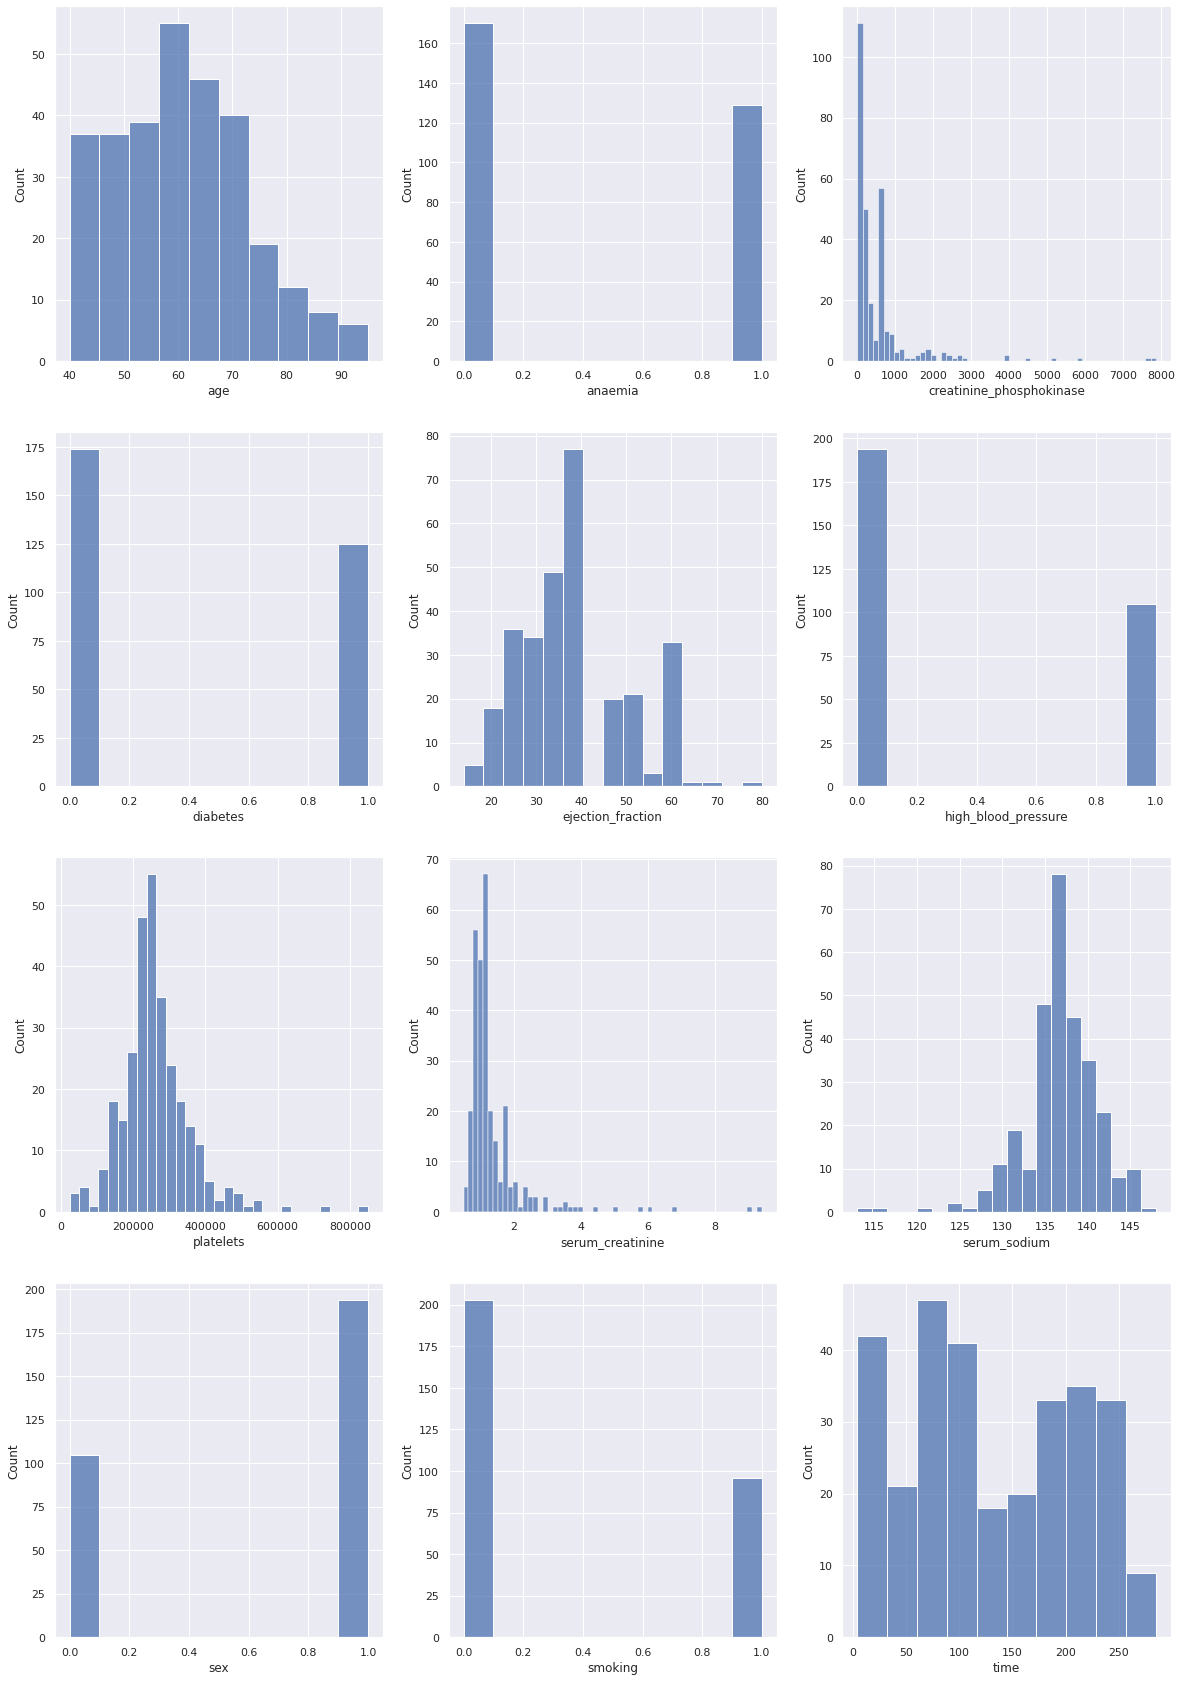

In [49]:
plt.figure(figsize=(20,30))

for i, column in enumerate(dataset.drop(["DEATH_EVENT"], axis=1).columns, 1):
    plt.subplot(4,3,i)
    sns.histplot(dataset[column])
plt.show()

## Linear Correlation of the different features:
As we can see **age, serum_creatinine** are linearly correlated with DEATH_EVENT; while **time, ejection_fraction, serum_sodium** are inversely correlated with DEATH_EVENT.

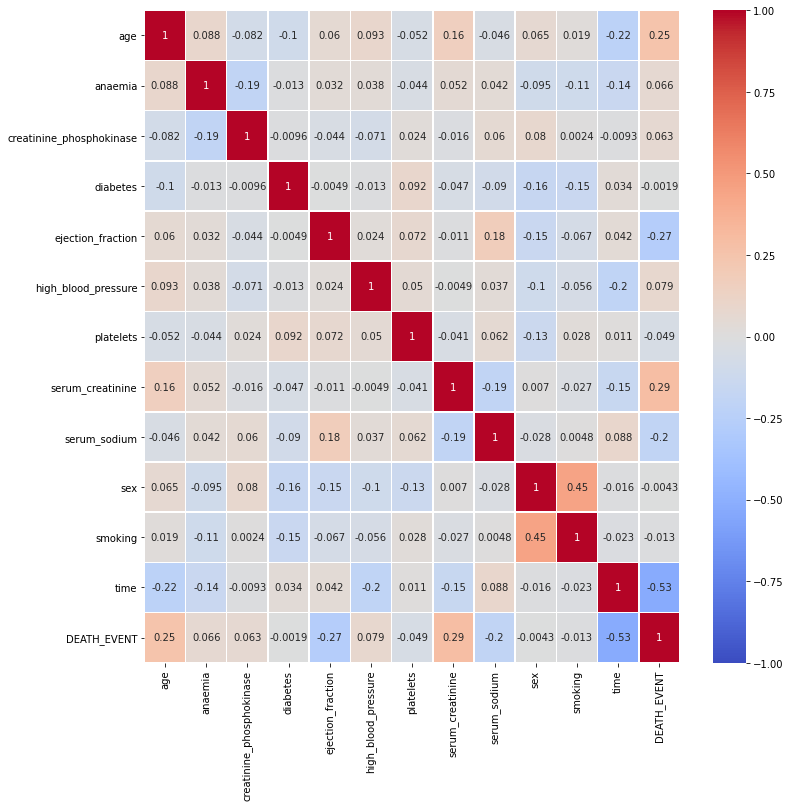

In [173]:
corr = dataset.corr()
ax, fig = plt.subplots(figsize=(12,12))
sns.heatmap(corr, vmax=1,vmin=-1, annot=True, linewidths=.5, cmap="coolwarm")
plt.show()

# Model Training
- We are gonna consider every single feature even if its less correlated. Because multiple features can form a **multiple correlation** with our output feature.
- We are gonna pick the best hyperparameter for each model aswell

In [174]:
# Splitting the dataset:
X = dataset.drop(["DEATH_EVENT"], axis=1)
y = dataset["DEATH_EVENT"]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)

# Standardize the training set using the training set means and standard deviations. 
# Standardize Test set using the training set means and standard deviations.
std_scalar = StandardScaler()
std_scalar.fit(X_train)
print(std_scalar.mean_)
X_train = std_scalar.transform(X_train)
X_test = std_scalar.transform(X_test)

[6.10599749e+01 4.35146444e-01 5.77083682e+02 4.05857741e-01
 3.82635983e+01 3.51464435e-01 2.62427450e+05 1.38736402e+00
 1.36418410e+02 6.44351464e-01 3.13807531e-01 1.32297071e+02]


In [175]:
def print_grid_scores(grid_search):
    """
    Prints the Mean scores and its corresponding hyperparameter for each candidate in GridSearchCV
    """
    grid_scores = grid_search.cv_results_
    best_mean_score = 0
    best_param = None
    for mean_score, params in zip(grid_scores["mean_test_score"], grid_scores["params"] ):
        if mean_score > best_mean_score:
            best_mean_score = mean_score
            best_param = params

        print("%.4f" % mean_score, params)
    print(f"Best Param:", "%.4f" % best_mean_score, best_param)

def print_test_scores(model, X_test=X_test, y_test=y_test):
    """
    Use the given model to test the model on the Test Set
    Then display the various scores and confusion matrix by comparing against y_test
    """
    y_test_pred = model.predict(X_test)

    # Evalution
    acc = accuracy_score(y_test, y_test_pred)*100
    pre = precision_score(y_test, y_test_pred)*100
    rec = recall_score(y_test, y_test_pred)*100
    f1 = f1_score(y_test, y_test_pred)*100
    print('Accuracy Score : ', "{:.2f}%".format(acc))
    print('Precision Score : ', "{:.2f}%".format(pre))
    print('Recall Score : ', "{:.2f}%".format(rec))
    print('F1 Score : ', "{:.2f}%".format(f1))
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()


## 1. Logistic Regression

In [239]:
RANDOM_STATE=42
REFIT = True
SCORING = "f1"
CV = 5
N_JOBS = 10

log_reg = LogisticRegression(random_state=RANDOM_STATE)
log_reg_parameters = {
    "penalty": ["l2"],
    'C': [0.1, 0.5 ,1]
    }
log_reg_grid = GridSearchCV(log_reg, log_reg_parameters, refit=REFIT, scoring = SCORING, verbose=2, cv=CV, n_jobs=N_JOBS)
log_reg_grid.fit(X_train, y_train)
print_grid_scores(log_reg_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.6170 {'C': 0.1, 'penalty': 'l2'}
0.6734 {'C': 0.5, 'penalty': 'l2'}
0.6734 {'C': 1, 'penalty': 'l2'}
Best Param: 0.6734 {'C': 0.5, 'penalty': 'l2'}


Accuracy Score :  78.33%
Precision Score :  92.86%
Recall Score :  52.00%
F1 Score :  66.67%


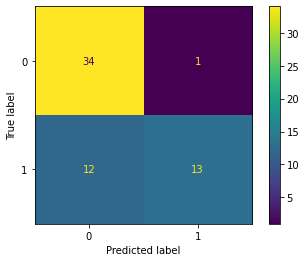

In [187]:
# Since refit=True, the model is refitted using the best parameter and is available via best_estimator
log_reg_best = log_reg_grid.best_estimator_
print_test_scores(log_reg_best)

## 2. Support Vector Classifier:

In [178]:
svc = SVC(random_state=RANDOM_STATE)
svc_parameters = {
    'C': [0.1, 0.5, 1, 5, 10],
    'kernel': ['linear'],
}
svc_grid = GridSearchCV(svc, svc_parameters, refit=REFIT, scoring = SCORING, verbose=2, cv=CV, n_jobs=N_JOBS)
svc_grid.fit(X_train, y_train)
print_grid_scores(svc_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.6585 {'C': 0.1, 'kernel': 'linear'}
0.6593 {'C': 0.5, 'kernel': 'linear'}
0.6789 {'C': 1, 'kernel': 'linear'}
0.6711 {'C': 5, 'kernel': 'linear'}
0.6655 {'C': 10, 'kernel': 'linear'}
Best Param: 0.6789 {'C': 1, 'kernel': 'linear'}


Accuracy Score :  80.00%
Precision Score :  88.24%
Recall Score :  60.00%
F1 Score :  71.43%


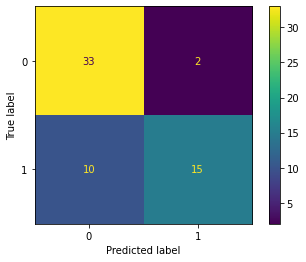

In [179]:
svc_best = svc_grid.best_estimator_
print_test_scores(svc_best)

## 3. Decision Tree Classifier:

In [232]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_parameters = {
    'criterion': ['gini'],
    'max_depth': [1,None],
    'max_features': [2,None],
    'max_leaf_nodes': [1,2,None]
}
dt_grid = GridSearchCV(dt, dt_parameters, refit=REFIT, scoring = SCORING, verbose=2, cv=CV, n_jobs=N_JOBS)
dt_grid.fit(X_train, y_train)
print_grid_scores(dt_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 1}
0.4759 {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': 2}
0.4759 {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'max_leaf_nodes': None}
nan {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 1}
0.7374 {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': 2}
0.7374 {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None}
nan {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 1}
0.4759 {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 2}
0.5912 {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'max_leaf_nodes': None}
nan {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 1}
0.7374 {'criterion': 'gini', 'max_depth': None, 'max_features': None

Accuracy Score :  75.00%
Precision Score :  81.25%
Recall Score :  52.00%
F1 Score :  63.41%


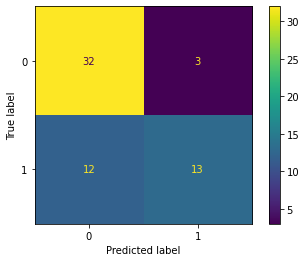

In [233]:
dt_best = dt_grid.best_estimator_
print_test_scores(dt_best)

## 4. Random Forest Classifier

In [224]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_parameters = {
    'criterion': ['gini'],
    'max_depth': [2,5,None],
    'n_estimators': [100,None],
    'max_leaf_nodes': [5,8, None]
}
rf_grid = GridSearchCV(rf, rf_parameters, refit=REFIT, scoring = SCORING, verbose=2, cv=CV, n_jobs=N_JOBS)
rf_grid.fit(X_train, y_train)
print_grid_scores(rf_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0.6451 {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100}
nan {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': None}
0.6451 {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 8, 'n_estimators': 100}
nan {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 8, 'n_estimators': None}
0.6451 {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': 100}
nan {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': None, 'n_estimators': None}
0.7829 {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 5, 'n_estimators': 100}
nan {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 5, 'n_estimators': None}
0.7759 {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': 100}
nan {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 8, 'n_estimators': None}
0.8004 {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': None, 'n_e

Accuracy Score :  75.00%
Precision Score :  85.71%
Recall Score :  48.00%
F1 Score :  61.54%


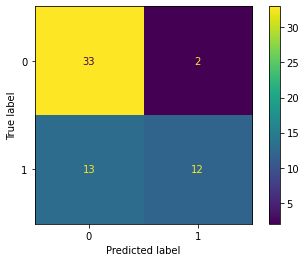

In [234]:
rf_best = rf_grid.best_estimator_
print_test_scores(rf_best)

## 5. Gradient Boosting Classifier

In [251]:
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf_parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.5, 0.05],
    'n_estimators': [50,100,150],
    'max_depth': [1,3,5],

}
gb_clf_grid = GridSearchCV(gb_clf, gb_clf_parameters, refit=REFIT, scoring = SCORING, verbose=2, cv=CV, n_jobs=N_JOBS)
gb_clf_grid.fit(X_train, y_train)
print_grid_scores(gb_clf_grid)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0.7787 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'n_estimators': 50}
0.8022 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'n_estimators': 100}
0.7891 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'n_estimators': 150}
0.6990 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 50}
0.7124 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 100}
0.7312 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 150}
0.6591 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 50}
0.6645 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
0.6854 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 150}
0.7696 {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 1, 'n_estimators': 50}
0.7845 {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 1, 

Accuracy Score :  73.33%
Precision Score :  84.62%
Recall Score :  44.00%
F1 Score :  57.89%


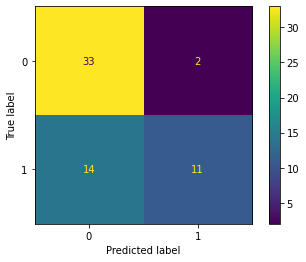

In [237]:
print_test_scores(gb_clf_grid.best_estimator_)

## 6. K Nearest Neighbors

In [246]:
knn_clf = KNeighborsClassifier()
knn_clf_parameters = {
    'n_neighbors': [2,3,5,8,10],
}
knn_clf_grid = GridSearchCV(knn_clf, knn_clf_parameters, refit=REFIT, scoring = SCORING, verbose=2, cv=CV, n_jobs=N_JOBS)
knn_clf_grid.fit(X_train, y_train)
print_grid_scores(knn_clf_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.1952 {'n_neighbors': 2}
0.4058 {'n_neighbors': 3}
0.4070 {'n_neighbors': 5}
0.2479 {'n_neighbors': 8}
0.2444 {'n_neighbors': 10}
Best Param: 0.4070 {'n_neighbors': 5}


Accuracy Score :  68.33%
Precision Score :  87.50%
Recall Score :  28.00%
F1 Score :  42.42%


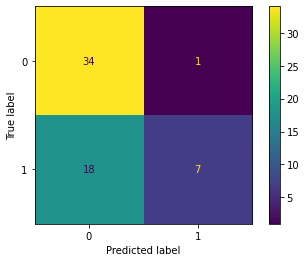

In [245]:
print_test_scores(knn_clf_grid.best_estimator_)

# Final Results:

## 1. Logistic Regression:
Accuracy Score :  78.33%

Precision Score :  92.86%

Recall Score :  52.00%

F1 Score :  66.67%

## 2. Support Vector Classifier:
Accuracy Score :  80.00%

Precision Score :  88.24%

Recall Score :  60.00%

F1 Score :  71.43%

## 3. Decision Tree Classifier:
Accuracy Score :  75.00%

Precision Score :  81.25%

Recall Score :  52.00%

F1 Score :  63.41%

## 4. Random Forst Classifier:
Accuracy Score :  75.00%

Precision Score :  85.71%

Recall Score :  48.00%

F1 Score :  61.54%

## 5. Gradient Boosting Classifier:
Accuracy Score :  73.33%

Precision Score :  84.62%

Recall Score :  44.00%

F1 Score :  57.89%

## 6. K Nearest Neighbors:
Accuracy Score :  68.33%

Precision Score :  87.50%

Recall Score :  28.00%

F1 Score :  42.42%